In [1]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
import os
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!unzip si650winter11.zip

Archive:  si650winter11.zip
  inflating: training.txt            
  inflating: testdata.txt            


In [3]:
#Data exploration
maxlen = 0
word_freq = collections.Counter()
num_rec=0
with open("training.txt", 'r') as file:
  for line in file:
    label, sentence = line.strip().split('\t')
    words = nltk.word_tokenize(sentence.lower())
    maxlen = max(len(words), maxlen)
    for word in words:
      word_freq[word] +=1
    num_rec += 1
print("maxlen: ", maxlen)
print("len(word_freq): " ,len(word_freq))

maxlen:  42
len(word_freq):  2328


In [0]:
#Data preprocessing
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40
vocab_size = min(MAX_FEATURES, len(word_freq)) + 2
word2index = { x[0] : i+2 for i, x in enumerate(word_freq.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}
X = np.empty((num_rec, ), dtype = list)
y = np.zeros((num_rec, ) )
i = 0
with open("training.txt", 'r') as file:
  for line in file:
    label, sentence = line.strip().split('\t')
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
      if word in word2index.keys():
        seqs.append(word2index[word])
      else:
        seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
X = sequence.pad_sequences(X, maxlen = MAX_SENTENCE_LENGTH)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=156)

In [6]:
#Build model
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 10

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, 
                    input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# Trainning model
Sentiment_Analysis = model.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                               epochs=EPOCHS, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 22s 4ms/step - loss: 0.2398 - acc: 0.8934 - val_loss: 0.0681 - val_acc: 0.9810
Epoch 2/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0288 - acc: 0.9905 - val_loss: 0.0330 - val_acc: 0.9922
Epoch 3/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0092 - acc: 0.9974 - val_loss: 0.0326 - val_acc: 0.9915
Epoch 4/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0066 - acc: 0.9988 - val_loss: 0.0285 - val_acc: 0.9944
Epoch 5/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0042 - acc: 0.9991 - val_loss: 0.0612 - val_acc: 0.9803
Epoch 6/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0304 - val_acc: 0.9944
Epoch 7/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0031 - acc: 0.9

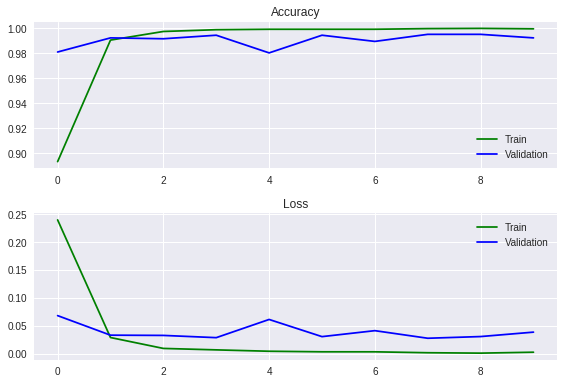

In [8]:
#Visualization
plt.subplot(211)
plt.title("Accuracy")
plt.plot(Sentiment_Analysis.history["acc"], color="g", label="Train")
plt.plot(Sentiment_Analysis.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(Sentiment_Analysis.history["loss"], color="g", label="Train")
plt.plot(Sentiment_Analysis.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [9]:
#Usage
score, acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test score: {:.3f}, accuracy:{:.3f} \n".format(score, acc))

print("{:^5}{:^6}{:<}".format("pred", "label", "sentence"))
for i in range(10):
  test_index = np.random.randint(len(X_test))
  X_t = X_test[test_index].reshape(1, 40)
  y_t = y_test[test_index]
  y_pred = model.predict(X_t)[0][0]
  test_sentence = " ".join([index2word[x] for x in X_t[0].tolist() if x !=0])
  print("{:^5.0f}{:^6.0f}{:<}".format(round(y_pred), y_t, test_sentence))

1418/1418 [==============================] - 2s 1ms/step
Test score: 0.038, accuracy:0.992 

pred label sentence
  0    0   this quiz sucks and harry potter sucks ok bye..
  1    1   da vinci code is amazing .
  0    0   da vinci code sucks .
  0    0   the da vinci code sucked big time .
  0    0   i heard da vinci code sucked soo much only 2.5 stars :
  0    0   by the way , the da vinci code sucked , just letting you know ...
  1    1   the da vinci code was awesome , i ca n't wait to read it ...
  1    1   i mean , of course , you know that i love brokeback mountain , which , i confess , might make my judgement biased .
  0    0   combining the opinion / review from gary and gin zen , the da vinci code sucks .
  1    1   the people who are worth it know how much i love the da vinci code .
